# Artifacts in EEG Data

Recall that the term **artifact** in EEG refers to any noise in the data that can be attributed to a specific source. So eye blinks, eye movements, and muscle contractions are all types of artifacts. It is important to remove these from the data, to increase our confidence that the results we ultimately interpret are actually due to brain activity, and not these other sources.

Common physiological artifacts, including eye blinks, eye movements, and muscle contractions, have highly characteristic properties in time and frequency. Examples of each are shown below:

### Eye blink

There are a series of several eye blinks in the data below, the first at 242 s. You can see that the size of eye blink artifacts are typically on the order of 10x as large as ongoing EEG, which is why they are such a problem. Note that we have scaled the amplitude scale (*y* axis) of the EEG data differently than in the plots above, so that the ongoing EEG is quite flat, and the blinks stand out more clearly.

```{figure} images/eog_blink.png
---
height: 400px
align: center
---
Examples of blink artifacts in EEG data.
```

Because the artifact originates at the eyes, is is picked up most strongly by the electrodes on the forehead, Fp1 and Fp2, as well as other frontal electrodes (the ones whose labels start with *F*, though much smaller). The electrical potential sharply increases, then decreases, over a period of about 250-300 ms for a typical blink. The artifact actually *inverts* at more posterior electrodes, for example at TP9 and TP10 in the figure above. These are the characteristic properties of an eye blink artifact, which can be used to identify them.  

### Eye movements

The neurons in the retina are organized in a highly oriented fashion, such that they form an electrical **dipole** — a source with positive and negative poles. This is exactly the kind of electrical source that EEG is good at detecting. As long as the eye's position doesn't change, the diploe created by the retina doesn't affect EEG recordings, because it is constant (not changing). However, as the eye moves to look at different locations in space, the dipole moves, and this is detected by the electrodes on the scalp. When they eyes move to the left or right, the effect on EEG electrodes is that the electrical potential will increase at frontal electrodes on one side of the head, and decrease on the other side. Which side becomes more positive or negative depends on the direction of the movement. 

An example of a horizontal eye movement is shown in the figure below, overlapping the time where the vertical green line is shown (this line is an event marker, but this is irrelevant for our present purposes). At electrodes Fp1 and Fp2, the artifact looks very similar to a blink. However, note how there is a roughly "square wave" effect at electrodes F7 and F8 (and to a lesser extent, at F3 and F4), and that this goes positive at F7/F3, and negative at F8/F4. This is the hallmark of a horizontal eye movement artifact. In the example below, the horizontal eye movement is followed by two blinks. We can tell these are blinks because the polarity (direction of change) at both F7 and F8 is the same (positive/upward).

```{figure} ./images/eog_horiz.png
---
height: 400px
align: left
---
Example of horizontal eye movement artifact in EEG data.
```

### Muscle contractions

In the figure below, note the increase in high frequency activity starting just after 872 s, especially at channels F3, F7, and TP9. This is typical of a muscle contraction, likely of the face and/or neck. Brief contractions like this are usually not a problem, but if the participant is tense throughout the experiment, or at least for extended periods, then this high frequency noise can make it more challenging to detect ERPs. Muscle contractions typically have a fairly broad frequency range, from about 20-40 Hz, which means that this artifact will be present even after the data is band-pass filtered.

```{figure} images/eeg_muscle.png
---
height: 400px
align: left
---
Example of muscle contraction artifact in EEG data.
```

## Artifact removal with Independent Components Analysis (ICA)

ICA is a *blind source separation* algorithm. In other words, it can take a complex signal and separate it into mathematically independent *components*. Note that the term "components" here is not used in the sense of ERP components (like the N170 or N400) that were discussed earlier. Rather, in ICA *components* are the individual underlying signals that were mixed together during recording. So for example, in EEG each electrode will record a mixture of brain activity (which itself may comprise multiple sources within the brain, such as the activity of different brain areas) and noise (including physiological and non-physiological artifacts). ICA is capable of separating EEG from artifacts (and separating different types of artifacts) because, over time and across all of thr recording electrodes, each signal with a different source will have different spatio-temporal properties. 

A nice example of using ICA, that may seem a. bit less abstract than EEG data, is audio recording. Imagine that we have two people in a room having a conversation, and there is background noise in the room such as from the ventilation system. If we have a single microphone in the room, all three signals (person A, person B, and the ventilation) will be mixed in the recording and it will be hard to separate them. However, if we have three microphones at different locations in the room, then each will pick up all three sound sources, but to different degrees depending on the location of each microphone. ICA can use the audio from all three microphones to find independent sources in the data (i.e., person A, person B, and the ventilation), based on how the sounds from each person, and the ventilation, differ systematically across the three microphones. But this only works because we have multiple independent sources (the microphones) sampling the data from different locations.

Likewise with EEG, it is necessary to have multiple electrodes (the sources) to run ICA. The maximum number of ICA components  that can be derived from a data set is equal to the number of electrodes (channels) we have. However, in practice the number of independent sources in the data is lower than the number of electrodes, and we can limit the number of ICA components accordingly, as we'll see below. 

In EEG, ICA has become widely used for artifact identification and removal. This is because it does a very good job of identifying ocular artifacts (blinks and eye movements), and also usually muscle artifact as well. Moreover, because the different ICA components are mathematically independent of each other, having identified which components are "noise" (such as blinks), we can remove these components from the data without affecting the other components. This means we can effectively remove the effects of ocular artifacts from the data, while preserving the EEG signals. This is usually preferable to older approaches, such as removing any trial containing an artifact from the data set completely. ICA allows us to remove artifacts while keeping all of the trials. 

### Filter data for ICA

ICA is very good at capturing features of the data that explain the most *variance*. Recall that variance, statistically speaking, is any deviation from the mean. Blinks and eye movements are well-captured by ICA because they are so much larger than EEG, and so they contain a lot of the variance in the EEG recordings. Likewise, low-frequency drift in the data explains large amounts of variance, because of the 1/f property of EEG data discussed earlier — the lowest frequencies contain the most power. For this reason, ICA works best on data that has more low-frequency power removed than the data that we ultimately want to analyze. So we will filter the data for ICA with a 1 Hz high-pass cutoff, rather than a 0.1 Hz cutoff as we used above. A useful property of ICA is that we can compute ICA based on a more-filtered version of the data, identify the artifacts based on this, and then apply the same ICA decomposition (i.e., how ICA breaks the data down into components) to the data that were filtered as we wanted for ERP analysis. Below we do this, running the same filtering command as we did in the previous lesson, except with a different high-pass (low frequency) cut-off. 

First we import MNE and load the raw data:

In [1]:
import mne
mne.set_log_level('error')  # reduce extraneous MNE output

# Participant ID code
p_id = 'N400_dataset_14'
data_dir = 'data'

raw = mne.io.read_raw_fif(data_dir + '/' + p_id + '-raw.fif', preload=True)

In [2]:
# Filter settings
ica_low_cut = 1.0       # For ICA, we filter out more low-frequency power
hi_cut  = 30

raw_ica = raw.copy().filter(ica_low_cut, hi_cut)

## Segment data for ICA

ICA likes to work with segments of data, rather than the continuous raw data. We call segments of EEG data **epochs**, a word which means "a period of time". Typically when talking about ERPs, *epochs* refers to the segments of data that are time-locked to experimental events of interest. Here, however, we use the term more generically to refer to any segment of EEG data. So here we will segment the entire raw data recording into a series of consecutive 1 s segments (ignoring the event markers for now), and save these as `epochs_ica`.

In [3]:
# Break raw data into 1 s epochs
tstep = 1.0
events_ica = mne.make_fixed_length_events(raw_ica, duration=tstep)
epochs_ica = mne.Epochs(raw_ica, events_ica,
                        tmin=0.0, tmax=tstep,
                        baseline=None,
                        preload=True)

Next we run a function from the [`autoreject`](https://autoreject.github.io/stable/index.html) package (an add-on to MNE) that will look at the data and automatically determine a threshold to use to find sections of the data that are excessively noisy. This can occur, for example, if a participant scratches their head during a recording, or sneezes, or for various other reasons. These "one-off" (or *paroxysmal* if you like fancy words) sources of noise can create large artifacts in the data. Since large amplitudes mean high variance, the presence of these artifacts can interfere with ICA's finding more frequent artifacts like blinks — since blinks are larger than EEG data, but smaller than these one-off sources of noise. 

In [4]:
from autoreject import get_rejection_threshold

reject = get_rejection_threshold(epochs_ica);
reject

Estimating rejection dictionary for eeg


{'eeg': 0.00010817971884733591}

### Fit ICA to data

Running ICA on our data involves two steps: 
1. Create an `ICA` object with the parameters (kwargs) that we want to use
1. `fit` this object to the data — which effectively runs the algorithm on the data, using the parameters set in step 1

This may seem overly complex — why define and object and then apply a `.fit()` method, rather than having a method that we just apply to the data in a single step/line of code?  

The reason relates to the nature of object-oriented languages. By creating an `ICA` object, we have a data structure — separate from the EEG data itself — that stores important information about this preprocessing step. After we fit the `ICA` object to the data, the object contains the values that were estimated from the data. In other words, running `.fit()` on the data *doesn't change the data itself*, only the `ICA` object. That way, this step is "non-destructive" in the sense that if we aren't happy with the results, we don't need to worry about re-loading our data — we can simply modify parameters of the `ICA` object and re-fit it. We'll do this for ICA as well; later in the course we'll see that this is actually the primary way in which machine learning and statistical models are fit to data sets in Python. 

The first parameter that we want to specify is the number of independent components we want. Recall that by default, ICA will compute as many components as there are channels in the data, but this is typically more than is necessary or useful. The `n_components` parameter of ICA can be specified in one of two ways. One is to provide an integer specifying the actual number of components desired. An optimal number for this, however, is hard to know in advance. The other way is to specify a floating point number ≤ 1, which represents the percentage of data that the ICA components should, collectively, explain. Here we use `.99`, which means we want as many independent components as needed to explain 99% of the variance in the data. Typically this is a good value to use.

The other parameter is `random_state`. We use this because ICA is an *iterative* algorithm that starts with a set of random parameters, and then over a series of fitting steps computes the optimal values of these parameters. The set of random parameters it starts with determines the results to some extent. That is, if you fit ICA repeatedly to the data, you will generally get very similar, but not identical, results each time, because of the different random starting points. By specifying a `random_state`, we ensure that the same "random" parameters are used each time, meaning that our results will be replicable. The value 42 is used by convention, because it is the "Answer to the Ultimate Question of Life, the Universe, and Everything" in *The Hitchhiker's Guide to the Galaxy* (Adams, 1979).

In fitting ICA to the data, we include a couple of other parameters, which were defined earlier. `reject` comes from `get_rejection_threshold`, and `tstep` is the 1 s intervals that we segmented our data in. 

In [5]:
# ICA parameters
random_state = 42   # ensures ICA is reproducible each time it's run
ica_n_components = .99     # Specify n_components as a decimal to set % explained variance

# Fit ICA
ica = mne.preprocessing.ICA(n_components=ica_n_components,
                            random_state=random_state,
                            )
ica.fit(epochs_ica,
        reject=reject,
        tstep=tstep)

Method,fastica
Fit,31 iterations on epochs (624747 samples)
ICA components,8
Available PCA components,16
Channel types,eeg
ICA components marked for exclusion,—


The `.fit()` step produces the output you see above, showing some of the resulting parameters stored in `ica`.

### Visualize ICA components


Every IC (an independent component identified by ICA) is a signal that varies over time, that has a "weighting" at each channel - reflecting how strongly present that IC is in that channel. In other words, the time course of an IC is the same at all electrodes, but it is bigger at some, and smaller at others. 

We can visualize each component as a **scalp topography map**, showing where on the scalp the IC is largest. *Topo maps*, as they are often abbreviated, are a different way of visualizing EEG data than we've seen before. Whereas previously we've viewed EEG as electrical potential over time, topo maps show how the potential are distributed spatially, at a specific point in time (or averaged over a period of time). The maps use the red-blue colour map where red is positive, blue is negative, and white is zero. "Positive" and "negative" in ICA topo maps can reflect cases where a component has the same shape over time, but opposite (negative vs. positive) electrical polarity at different scalp locations. This can be seen, for example, in `ICA001` below, which reflects the opposite polarities induced by horizontal eye movements.

Indeed, in the figure below we can see that a few ICs are likely ocular artifacts, because they weight most heavily around the front of the head (the top of each subplot, where the nose is drawn). In particular, `ICA000` is likely blink artifact, and `ICA001` is likely horizontal eye movement. `ICA002` may be eye movement as well.


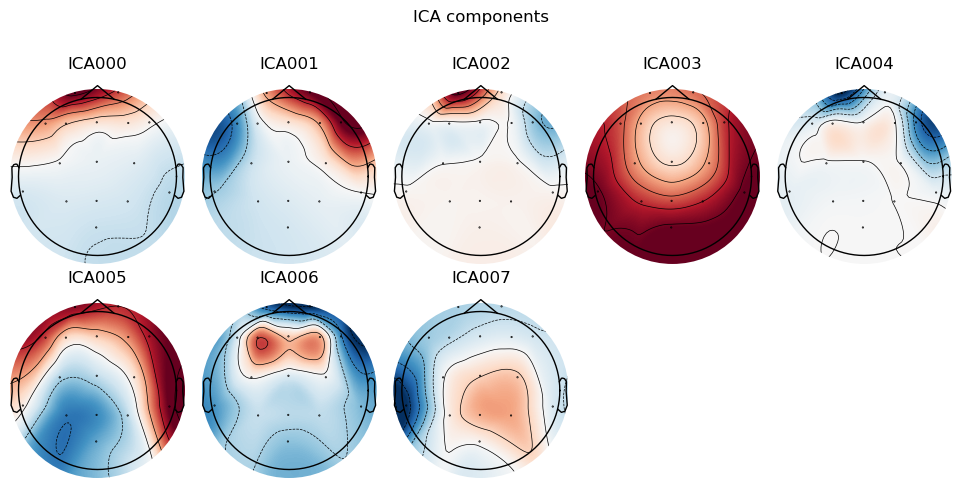

In [6]:
ica.plot_components();

### Plot IC properties

We can use the `.plot_properties()` method of the ICA class to view more details of each IC. Moving clockwise from top left, the four subplots for each IC are:
- topo map
- raster plot of how the IC weights on each trial. Artifacts like blinks should appear as "streaks" lasting about 200-300 ms, on relatively few trials. Components reflecting brain activity are typically present across many epochs (although remember that these data are segmented into 1 s epochs across the entire raw data set, so we would not expect to see time-locked activity here)
- Variance of the component, across channels and time. The *x* axis is epochs (effectively, time across the experiment), and the *y* axis is the variance of the IC across channels. Noise typically manifests as high variance on a low number of trials, and low variance on most trials, or lots of variability in the values on the *y* axis over epochs. True brain activity usually appears as consistently similar — and low — variance across epochs. 
- The PSD (phase spectral density) of the IC. EOG (eye) artifacts will typically have a peak at the low frequency end of the spectrum (the left side of the *x* axis), and muscle artifact will tend to show increasing power at the high end of the frequency spectrum (the right side of the *x* axis).  


With this in mind, `ICA000` is very characteristic of a blink artifact. The scalp topography is weighted most heavily at the electrodes right above the eyes (where blinks are most strongly detected) and the raster plot shows horizontal "streaks" on relatively few trials. The third plot shows high variance on a few trials, and the PSD is largest at the low end of the spectrum. 

`ICA001` shows similar properties, except that its scalp topography is maximal over the left and right anterior scalp locations, with opposite polarities (showing as blue vs. red). This is characteristic of horizontal eye movements.

Some of the other ICs may also be attributable to noise rather than EEG activity — for example ICs 4, 6, and 7. However, since these are not clearly well-defined ocular artifacts, we will not remove them. It is better to be conservative in terms of not removing too many ICs, than risking removing true brain activity.

Fortunately, as we'll see below, we don't necessarily need to make subjective judgment calls about which ICA components to reject (some researchers do reject ICs based on visual inspection, but this requires extensive training and experience, and is hard to reproduce). There are automated algorithms that attempt to do this objectively. However, it's worth knowing what artifacts look like, so that you can check the results of any automated approach to ICA component selection/rejection against your understanding of how they should work. Indeed, as we will see below, these automated algorithms are not always perfect.

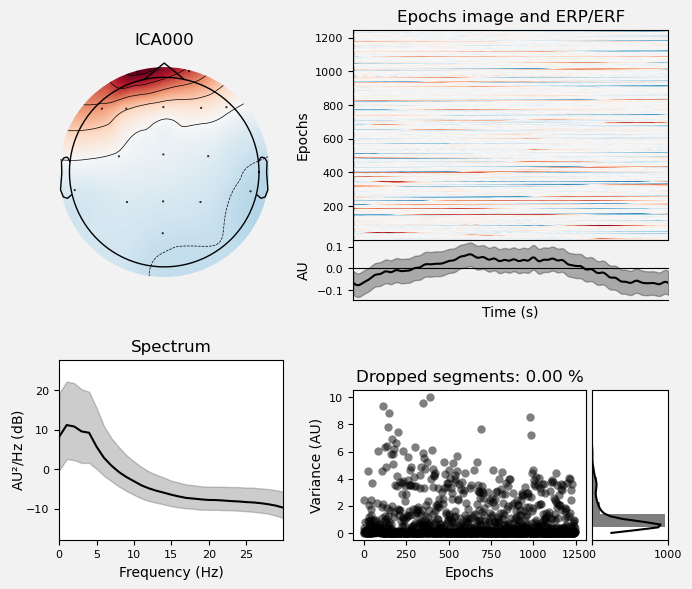

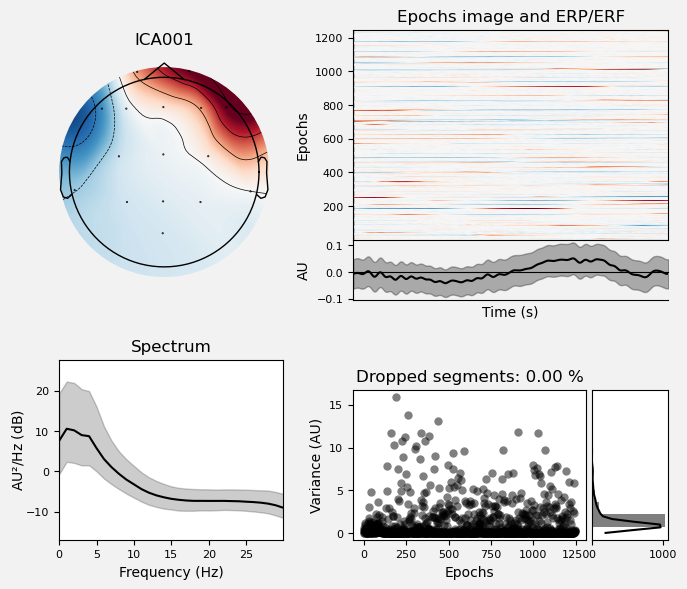

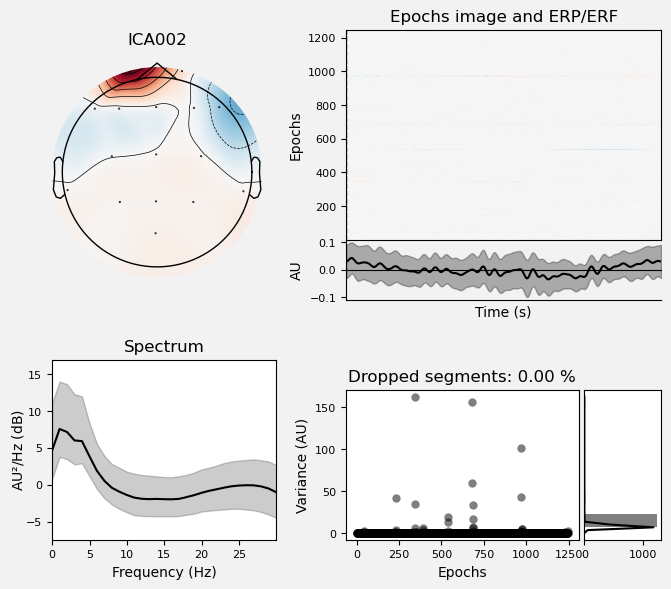

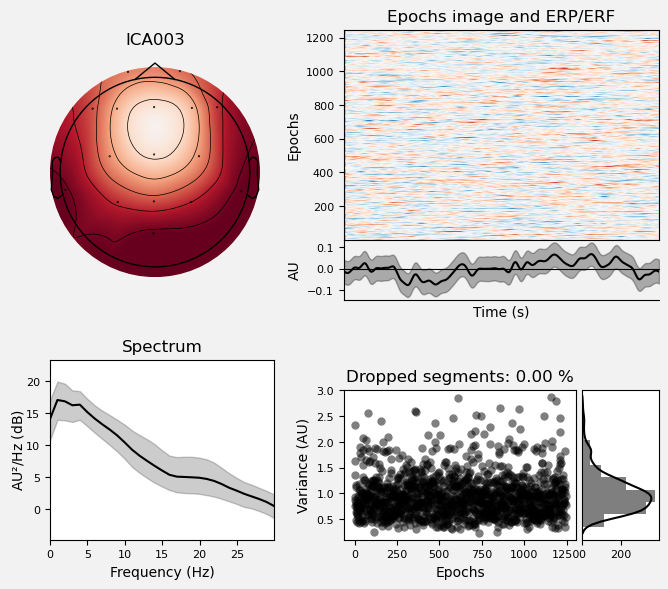

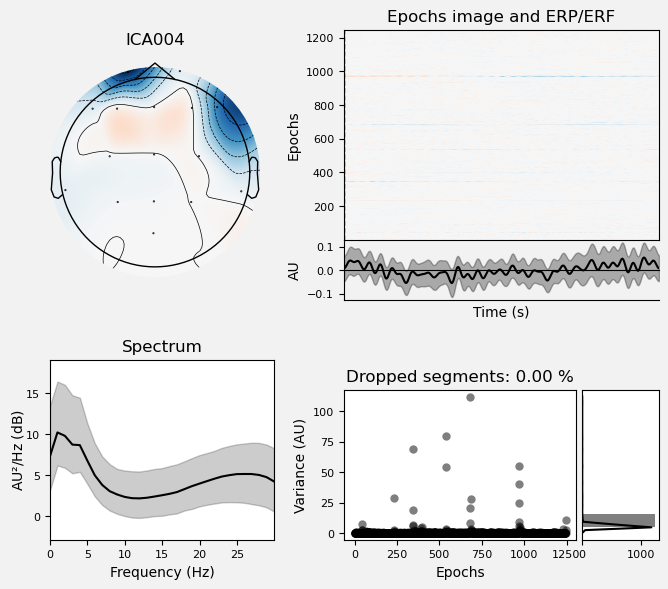

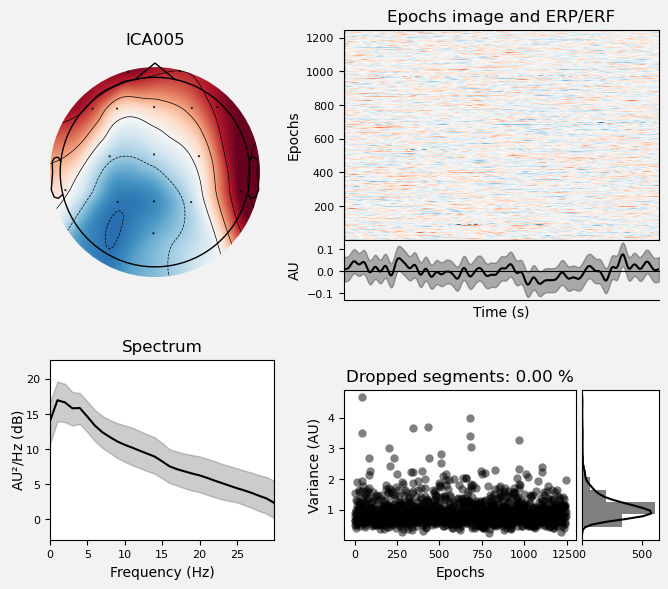

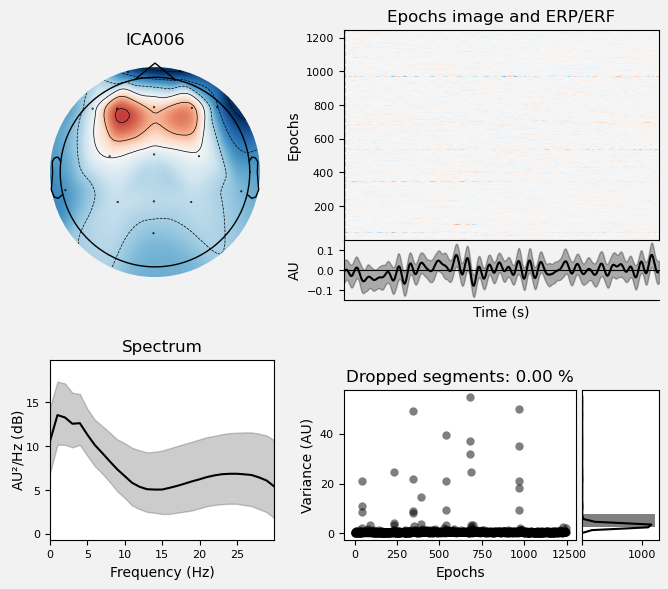

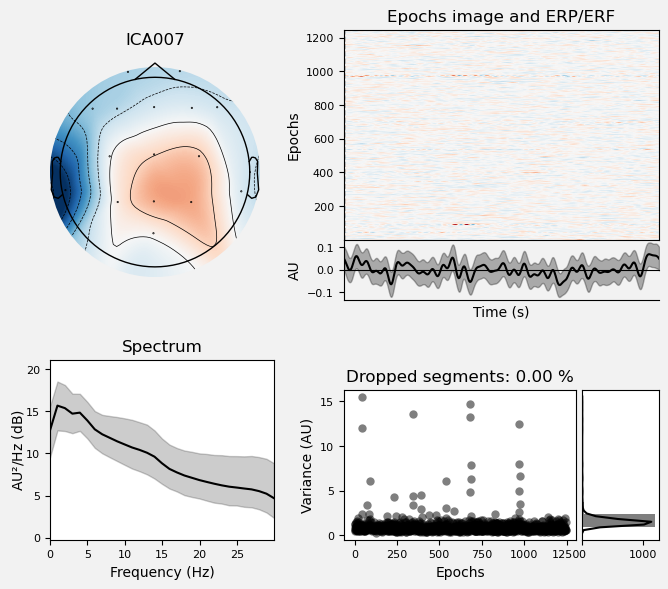

In [7]:
ica.plot_properties(epochs_ica, picks=range(0, ica.n_components_), psd_args={'fmax': hi_cut});

### Identify EOG artifacts from ICA components

MNE has an algorithm that attempts to automatically identify ICA components. The `find_bads_eog()` function computes correlations between each IC and channels that the researcher has designated as **EOG** (electro-oculogram) channels. These are electrodes, the same as EEG electrodes, but intentionally placed close to the eyes specifically to monitor for blinks and eye movements. These are typically placed above and below one eye (to monitor blinks and vertical eye movements, as well as on the temples of the head laterally to the eyes (to monitor horizontal eye movements).

In the present data set, unfortunately EOG was not recorded. However, the Fp1 and Fp2 electrodes are above the eyes, and F7 and F8 are close enough to the sides of the eyes to detect horizontal movements. `find_bads_eog()` takes a `ch_name` kwarg to allow us to specify EEG channels that we want to use in place of EOG channels; below we use Fp1 and F8 (we only need one channel each for blinks and horizontal movements). We add another kward to override the default correlation threshold of `find_bads_eog()` which, in my experience, does not work well for EEG data (although it does for MEG data) and use instead *z* > 1.96, which corresponds to a 5% chance of a correlation that large occurring due to chance.

MNE also provides a `.plot_scores()` method that will plot the correlation values for each IC, and mark any that were rejected in red.

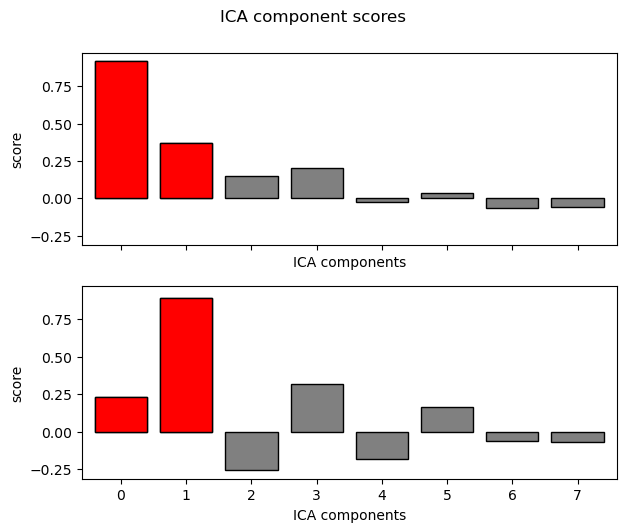

In [8]:
ica_z_thresh = 1.96 
eog_indices, eog_scores = ica.find_bads_eog(raw_ica, 
                                            ch_name=['Fp1', 'F8'], 
                                            threshold=ica_z_thresh)
ica.exclude = eog_indices

ica.plot_scores(eog_scores);

## Save ICA

In the next lesson we will segment our EEG data into epochs time-locked to experimental events of interest. After we do that, we will apply the ICA that we computed here to remove ocular artifacts from the epochs. So for now we will save the ICA object, which includes the `bads` attribute that indicates which components to reject as ocular artifacts. `ICA` objects have a `.save()` method that will create a `.fif` file:

In [9]:
ica.save(data_dir + '/' + p_id + '-ica.fif', 
        overwrite=True);